In [2]:
# Gensim
import gensim
from gensim.models import Word2Vec

import os

import pandas as pd
import numpy as np

# custom
from analize_text import get_sentenceID
from paths import *

# nltk
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk import pos_tag, pos_tag_sents

from multiprocessing import cpu_count

# scikit learn
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

# keras
from keras.utils import np_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# read dataframes of sentences and entities
sentences_df = pd.read_csv(SENTENCE_PATH)
entities_df = pd.read_csv(ENTITY_PATH)

In [4]:
print('Entities dataframe')
entities_df.head()

Entities dataframe


,entityID,name,position,type
0,DDI-DrugBank.d281.s0.e0,Probenecid,0-9,drug
1,DDI-DrugBank.d281.s0.e1,cephalosporins,51-64,group
2,DDI-DrugBank.d281.s0.e2,cephalosporin,132-144,group
3,DDI-DrugBank.d281.s3.e0,cephalosporins,56-69,group
4,DDI-DrugBank.d384.s0.e0,vitamin D analogues,17-35,group


In [5]:
print('Sentences dataframe')
sentences_df.head()

Sentences dataframe


,sentenceID,sentenceText
0,DDI-DrugBank.d281.s0,Probenecid may decrease renal tubular secretio...
1,DDI-DrugBank.d281.s1,Drug/Laboratory Test Interactions A false posi...
2,DDI-DrugBank.d281.s2,Positive direct and indirect antiglobulin (Coo...
3,DDI-DrugBank.d281.s3,these may also occur in neonates whose mothers...
4,DDI-DrugBank.d384.s0,Interactions for vitamin D analogues (Vitamin ...


### Load label dictionary {sentenceID: [ 'B', 'I', ..., 'O'] }

In [6]:
label_dict_path = os.path.join(ROOT_DIR, 'Train', 'bio_labels')
label_dict = np.load(label_dict_path + '.npy').item()

sentenceIDs = label_dict.keys()

In [12]:
# get sentences containing at least an entity 
sentences = [sentences_df[sentences_df.sentenceID == sentenceID]['sentenceText'].values[0] 
             for sentenceID in sentenceIDs]

# remove duplicates from sentence list (sentences with e.g. 2 entities appeared twice)
sentences = list(set(sentences))

In [13]:
### WTF ### happens iterating from sentences_df instead of indexing by entities 
dd = sentences_df['sentenceText']
for i, sentence in zip(range(len(dd)), dd.values):
    if not isinstance(sentence, str):
        print(i, True, sentence)
        break # remove this to see all

28 True nan


In [14]:
# just check nothing is wrong (it should not print anything)
for s in sentences:
    if not isinstance(s, str):
        print(True)

### Tokenize sentences

In [15]:
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
tokenized_sentences[0]

['Colestipol']

In [16]:
### EXAMPLE STEM + POS ####
# POS could differ slightly when applied to the stemmed version or not
# TODO: try which one performs better
stemmer = EnglishStemmer()
s = ['interaction', 'between', 'cimetidine', 'and', 'warfarin', 'could', 'be', 'dangerous']

print ('stemmed version:\n')
stemmed_s = [stemmer.stem(w) for w in s]
print (stemmed_s)

print ('\noriginal pos tags:\n')
print(pos_tag(s))

print ('\nstemmed pos tags:\n')
print(pos_tag(stemmed_s))

stemmed version:

['interact', 'between', 'cimetidin', 'and', 'warfarin', 'could', 'be', 'danger']

original pos tags:

[('interaction', 'NN'), ('between', 'IN'), ('cimetidine', 'NN'), ('and', 'CC'), ('warfarin', 'NN'), ('could', 'MD'), ('be', 'VB'), ('dangerous', 'JJ')]

stemmed pos tags:

[('interact', 'NN'), ('between', 'IN'), ('cimetidin', 'NN'), ('and', 'CC'), ('warfarin', 'NN'), ('could', 'MD'), ('be', 'VB'), ('danger', 'JJR')]


### POS tag

In [17]:
tokenized_sentences_pos = pos_tag_sents(tokenized_sentences, tagset=None) # tagset = None, 'universal', 'wsj', 'brown'

# concatenate the part of speach to each word (e.g. cat_NN)
tokenized_sentences_pos = [ [w + '_' + pos for w, pos in s ] for s in tokenized_sentences_pos]
tokenized_sentences_pos[0]

['Colestipol_NN']

### Prepend label of BIO label of previous word
TODO

### Word2Vec

In [16]:
vector_size = 20
model = Word2Vec(tokenized_sentences_pos, size=vector_size, window=5, min_count=1, workers=cpu_count(), compute_loss=True)
model.train(sentences, total_examples=len(sentences), epochs=10)
print ('latest loss:', model.get_latest_training_loss())

latest loss: 0.0


In [17]:
# save embeddings and delete model
model.save("../word_vectors")
#model = Word2Vec.load('../word_vectors')
word_vectors = model.wv
del model

In [21]:
print(word_vectors["conduction_NN"])

[-0.09216564  0.46637434  0.18663509 -0.19735047 -0.38259652 -0.24352658
 -0.16713165 -0.3233638   0.19811073  0.34190407  0.57070404  0.23984055
  0.07585726 -0.17945772 -0.36799774  0.08888565 -0.19151497  0.11343262
  0.38661858 -0.7281082 ]


#### create dataset

In [1]:
# create X_train, Y_train
X_train = np.array([]).reshape(0,vector_size)
Y_train = np.array([])

for sentenceID, labels in label_dict.items():
    sentence = sentences_df[sentences_df.sentenceID == sentenceID]['sentenceText'].values[0]
    tok_sentence = word_tokenize(sentence)
    tok_sentence_pos = [ word + '_' + pos for word, pos in pos_tag(tok_sentence, tagset=None)]

    for word, label in zip(tok_sentence_pos, labels):
        word_vector = word_vectors[word]
        print(word_vector, label)
        X_train = np.vstack((X_train, word_vector))
        Y_train = np.append(Y_train, label)       

NameError: name 'np' is not defined

In [25]:
print (X_train.shape)
print (Y_train.shape)

(128806, 20)
(128806,)


### One-hot encoding of labels
Convert labels from B-I-O to $[1 0 0, 0 1 0, 0 0 1]$

In [26]:
# encode class values as integers = B-I-O -> 0-1-2
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y_train)
Y_train = encoded_Y
# convert integers to one-hot encoding
Y_train_one_hot = np_utils.to_categorical(encoded_Y) # SVM does not need one-hot encoding

## split train / validation set

In [17]:
# split train validation (SVM)
train_perc = 0.8
train_size = int(len(X_train) * train_perc)

X_tr, X_vl = X_train[:train_size,:], X_train[train_size:,:]
Y_tr, Y_vl = Y_train[:train_size], Y_train[train_size:]

print (X_tr.shape, X_vl.shape)
print (Y_tr.shape, Y_vl.shape)

((103044, 20), (25762, 20))
((103044,), (25762,))


In [21]:
# split train validatioin (NN)
Y_tr_nn, Y_vl_nn = Y_train_one_hot[:train_size], Y_train_one_hot[train_size:]

# Using SVM

In [35]:
from sklearn import svm

model = svm.SVC(kernel='rbf', C=1.0, class_weight=None, gamma='auto', tol=0.001, random_state=None)

In [36]:
model.fit(X_tr, Y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
print ('SVM validation accuracy:', round(model.score(X_vl, Y_vl),4))

('SVM validation accuracy:', 0.8648)


# Using ANN

In [25]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn import preprocessing
from keras.optimizers import *
from keras.initializers import *

import matplotlib.pyplot as plt

In [23]:
num_inputs = X_train.shape[1] # size of a vector
num_outputs = 3 # b-i-o tags

model = Sequential()

model.add(Dense(units=64, input_shape=(num_inputs,), activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 3,523
Trainable params: 3,523
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 10
batch_size = 10

history = model.fit(X_tr, Y_tr_nn, 
                    epochs=10, 
                    shuffle=True, verbose=1, 
                    batch_size=batch_size,
                    validation_data=(X_vl, Y_vl_nn))

Train on 103044 samples, validate on 25762 samples
Epoch 1/10
103044/103044 [==============================] - 35s 343us/step - loss: 0.3137 - acc: 0.8722 - val_loss: 0.2905 - val_acc: 0.8822
Epoch 2/10
103044/103044 [==============================] - 35s 344us/step - loss: 0.2857 - acc: 0.8809 - val_loss: 0.2748 - val_acc: 0.8823
Epoch 3/10
103044/103044 [==============================] - 36s 350us/step - loss: 0.2764 - acc: 0.8843 - val_loss: 0.2757 - val_acc: 0.8829
Epoch 4/10
103044/103044 [==============================] - 37s 358us/step - loss: 0.2712 - acc: 0.8861 - val_loss: 0.2670 - val_acc: 0.8835
Epoch 5/10
103044/103044 [==============================] - 35s 342us/step - loss: 0.2678 - acc: 0.8874 - val_loss: 0.2735 - val_acc: 0.8838
Epoch 6/10
103044/103044 [==============================] - 37s 356us/step - loss: 0.2640 - acc: 0.8886 - val_loss: 0.2987 - val_acc: 0.8723
Epoch 7/10
103044/103044 [==============================] - 38s 373us/step - loss: 0.2610 - acc: 0.8890

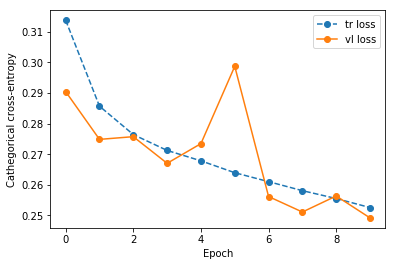

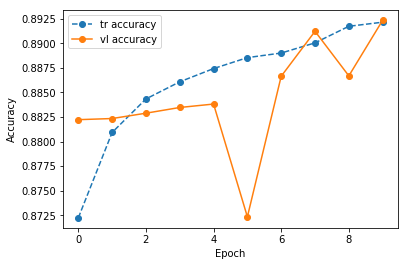

In [34]:
plt.plot(history.history['loss'], label='tr loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='vl loss', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Cathegorical cross-entropy')
plt.legend(loc='best')

plt.show()

plt.plot(history.history['acc'], label='tr accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_acc'], label='vl accuracy', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

# Test